# L-DED Audiovisual Fusion 

Author: Chen Lequn.
Created on 01 Feb 2023.

- Material： Maraging Steel 300
- Process: Robotic Llser-directed energy deposition
- Experiment number (single bead wall samples): 21-26
- Recorded data: position, veolocity, coaxial melt pool images, acoustic data
- Defect generated: keyhole pores, cracks, defect-free

### Notebook 4: Audiovisual fusion - baseline

- Testing on audio visual fusion with VGG-ish CNN model.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.multiprocessing as mp

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

import os
import argparse
from torch.utils.data import Subset
import pandas as pd
import numpy as np

# Scikit learn
#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample, class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from vision_models import * 
from audiovisual_models import *
from multimodaldataset import MultimodalDataset, LDEDAudioDataset, LDEDVisionDataset
from utils import *
from train_utils import train_single_epoch, test_single_epoch, training_loop

from torchviz import make_dot

## plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
import seaborn as sns

torch.manual_seed(0)





# # Multimodal_dataset_PATH = os.path.join("C:\\Users\\Asus\\OneDrive_Chen1470\\OneDrive - Nanyang Technological University\\Dataset\\Multimodal_AM_monitoring\\LDED_Acoustic_Visual_Dataset")
# Multimodal_dataset_PATH = os.path.join("/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset")
# Image_path = os.path.join(Multimodal_dataset_PATH,'Video', 'segmented',  'images')
# Audio_raw_seg_PATH = os.path.join(Multimodal_dataset_PATH, 'Video', 'segmented', 'raw_audio')
# Audio_equalized_seg_PATH = os.path.join(Multimodal_dataset_PATH, 'Video', 'segmented', 'equalized_audio')
# Audio_bandpassed_seg_PATH = os.path.join(Multimodal_dataset_PATH, 'Video', 'segmented', 'bandpassed_audio')
# Audio_denoised_seg_PATH = os.path.join(Multimodal_dataset_PATH,'Video', 'segmented',  'denoised_audio')

# AUDIO_DIR = Audio_raw_seg_PATH
# VISON_DIR = Image_path

# ANNOTATIONS_FILE = os.path.join(Multimodal_dataset_PATH, 'Video', 'segmented', "visual_acoustic_dataset_annotations_v2.csv")

In [2]:
def get_sample_directories(base_path, sample_numbers):
    sample_directories = []
    for sample_number in sample_numbers:
        sample_directories.append(os.path.join(base_path, f'segmented_25Hz/{sample_number}'))
    return sample_directories

Multimodal_dataset_PATH = "/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset"
samples = [21, 23]
sample_directories = get_sample_directories(Multimodal_dataset_PATH, samples)

# Get lists of image and audio directories for each sample
image_directories = [os.path.join(sample_dir, 'images') for sample_dir in sample_directories]
audio_directories = [os.path.join(sample_dir, 'denoised_audio') for sample_dir in sample_directories]

In [40]:
# classes = ('Laser-off', 'Defect-free', 'Defective')
classes = ('Laser-off', 'Defect-free', 'Cracks', "Keyhole pores")
SAMPLE_RATE = 44100
LEARNING_RATE = 0.00001
BATCH_SIZE = 32
EPOCHS = 50

### Utils functions

In [4]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'train_audio_visual')
os.makedirs(IMAGE_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

### Use GPU if possible

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")
# mp.set_start_method("spawn")
mp.set_start_method(method='forkserver', force=True)

Using cuda


### Annotation file

- Vision acoustic spatio-temporal registration has been done in our previous work. 
- Each frame (timestamp) corresponds to a robot TCP position.
- The duration for each frame is 0.01 seconds (sampling freqeuncy 10 Hz.)

In [6]:
# Combine all annotation files into one DataFrame
all_annotation_dfs = []
for sample_dir, sample_number in zip(sample_directories, samples):
    annotation_file = os.path.join(sample_dir, f'annotations_{sample_number}.csv')  # Update the file name
    annotation_df = pd.read_csv(annotation_file)
    all_annotation_dfs.append(annotation_df)
combined_annotation_df = pd.concat(all_annotation_dfs)

combined_annotation_df = combined_annotation_df.dropna(subset=['name'])
combined_annotation_df

,sample index,audio_file_name,image_file_name,class_name,class_ID,class_name_v2,class_ID_2,Layer number,Sample number
0,1,sample_21_1.wav,sample_21_1.jpg,Laser-off,0.0,Laser-off,0.0,1.0,21
1,2,sample_21_2.wav,sample_21_2.jpg,Crack,2.0,Defective,2.0,1.0,21
2,3,sample_21_3.wav,sample_21_3.jpg,Crack,2.0,Defective,2.0,1.0,21
3,4,sample_21_4.wav,sample_21_4.jpg,Crack,2.0,Defective,2.0,1.0,21
4,5,sample_21_5.wav,sample_21_5.jpg,Defect-free,1.0,Defect-free,1.0,1.0,21
...,...,...,...,...,...,...,...,...,...
11391,11392,sample_23_11392.wav,sample_23_11392.jpg,Laser-off,NaN,NaN,NaN,50.0,23
11392,11393,sample_23_11393.wav,sample_23_11393.jpg,Laser-off,NaN,NaN,NaN,50.0,23
11393,11394,sample_23_11394.wav,sample_23_11394.jpg,Laser-off,NaN,NaN,NaN,50.0,23
11394,11395,sample_23_11395.wav,sample_23_11395.jpg,Laser-off,NaN,NaN,NaN,50.0,23


In [7]:
# Get the labels and count the number of samples for each class
labels = combined_annotation_df['name'].values
label_counts = np.unique(labels, return_counts=True)[1]
print (label_counts)

[ 753 5363 2849 6362]


In [8]:
combined_annotation_df.iloc[1300,8]

21

### Basline accuracy
The baseline accuracy in this multi-class classificiation problem is **53%**, which is the accuracy of trivially predicting the most-frequent class (classify to the largest class– in other words).

In [9]:
### Get the percentage distribution of each category
round(combined_annotation_df.groupby('name')["name"].count()/combined_annotation_df.shape[0]*100, 1)

class_ID_2
0.0     2.5
1.0    15.1
2.0    16.0
Name: class_ID_2, dtype: float64

Saving figure dataset


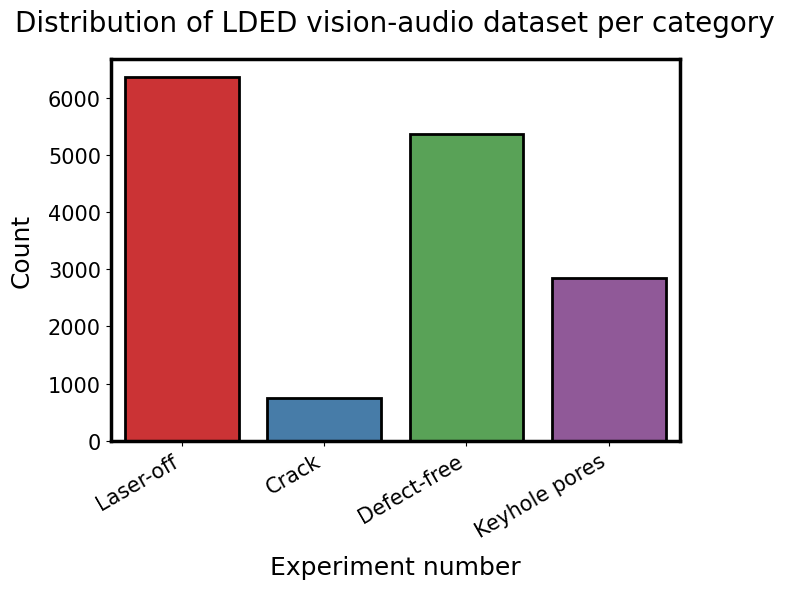

In [10]:
# sns.set(style="darkgrid")
plt.figure(figsize = (7,6))


ax = sns.countplot(x='name', data = combined_annotation_df, palette="Set1", linewidth=2,
                   edgecolor='k'); #palette='mako' 'Set2'
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
# ax = sns.countplot(y='label', data = df_dataset_denoised, palette="Set2");


ax.set_title('Distribution of LDED vision-audio dataset per category', fontsize = 20, pad=20);
ax.set_xlabel("Experiment number",fontsize=18, labelpad=10)
ax.set_ylabel("Count",fontsize=18, labelpad=10)
ax.tick_params(labelsize=15)

save_fig("dataset")

## Preparing Dataset and DataLoader

In [11]:
#------ transformation------
visual_train_transforms=transforms.Compose([
    torchvision.transforms.Resize((32,32)), # original image size: (640,480)
    transforms.RandomHorizontalFlip(),  # data augmentation
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
    transforms.ToTensor(),
    transforms.Normalize(mean=[63.66424300065244], std=[71.51866534828666]),
])

visual_val_transforms=transforms.Compose([
    torchvision.transforms.Resize((32,32)), # original image size: (640,480)
    transforms.ToTensor(),
    transforms.Normalize(mean=[63.66424300065244], std=[71.51866534828666]),
])

visual_test_transforms=transforms.Compose([
    torchvision.transforms.Resize((32,32)), # original image size: (640,480)
    transforms.ToTensor(),
    transforms.Normalize(mean=[63.66424300065244], std=[71.51866534828666]),
])

#------ audio transfomation------
# instantiating our dataset object and create data loader
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=512,
    hop_length=256,
    n_mels=32
)

MFCCs = torchaudio.transforms.MFCC(sample_rate=SAMPLE_RATE,n_mfcc=20)

/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [12]:
#------ data loader------
# create the dataset for all samples

mmd = MultimodalDataset(combined_annotation_df,
                            image_directories,
                            audio_directories,
                            samples,
                            visual_train_transforms,
                            mel_spectrogram,
                            SAMPLE_RATE,
                            device)

print ("length of the total dataset:" + str(len(mmd)))

length of the total dataset:15327


### Dealing with Imbalanced dataset: stratified sampling

- Split the data into train, validation, and test set
- Train and Val are used for hyperparameter tuning
- Train set will go through some data augmentation

In [13]:
# Split the data into train and validation datasets
# train_annotations, val_annotations = train_test_split(annotations_df, test_size=0.2)
# create the StratifiedShuffleSplit object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# split the indices of annotations into train and test sets
train_indices, test_indices = next(sss.split(combined_annotation_df, labels))

# split the data into train and test sets
train_annotations = combined_annotation_df.iloc[train_indices, :]
test_annotations = combined_annotation_df.iloc[test_indices, :]

# Create the train and validation datasets
train_dataset = MultimodalDataset(train_annotations,
                                  image_directories,
                                  audio_directories,
                                  samples,
                                  visual_train_transforms,
                                  mel_spectrogram,
                                  SAMPLE_RATE,
                                  device)

        
val_dataset = MultimodalDataset(test_annotations,
                                image_directories,
                                audio_directories,
                                samples,
                                visual_train_transforms,
                                mel_spectrogram,
                                SAMPLE_RATE,
                                device)

In [14]:
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# # split the indices of annotations into train, validation and test sets
# train_indices, test_val_indices = next(sss.split(annotations_df, labels))

# # Use another StratifiedShuffleSplit to split the test_val_indices into test and validation sets
# val_size = 0.5 # set the validation size
# sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=0)
# val_indices, test_indices = next(sss2.split(annotations_df.iloc[test_val_indices], labels[test_val_indices]))

# # split the data into train, validation, and test sets
# train_annotations = annotations_df.iloc[train_indices, :]
# val_annotations = annotations_df.iloc[val_indices, :]
# test_annotations = annotations_df.iloc[test_indices, :]

# # Create the train, validation and test datasets
# train_dataset = MultimodalDataset(train_annotations,
#                                   image_path = VISON_DIR,
#                                   audio_path = AUDIO_DIR,
#                                   image_transformation=visual_train_transforms,
#                                   MFCCs = MFCCs,
#                                   target_sample_rate = SAMPLE_RATE,
#                                   device=device)

# val_dataset = MultimodalDataset(val_annotations,
#                                 image_path = VISON_DIR,
#                                 audio_path = AUDIO_DIR,
#                                 image_transformation=visual_val_transforms,
#                                 MFCCs = MFCCs,
#                                 target_sample_rate = SAMPLE_RATE,
#                                 device=device)

# test_dataset = MultimodalDataset(test_annotations,
#                                  image_path = VISON_DIR,
#                                  audio_path = AUDIO_DIR,
#                                  image_transformation=visual_train_transforms,
#                                  MFCCs = MFCCs,
#                                  target_sample_rate = SAMPLE_RATE,
#                                  device=device)

### Create DataLoader using the dataset

In [15]:
# # Create train and val dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("length of the train dataset:" +  str(len(train_dataloader.dataset)))
print("length of the val dataset:" +  str(len(val_dataloader.dataset)))
# print("length of the test dataset:" +  str(len(test_dataloader.dataset)))

length of the train dataset:12261
length of the val dataset:3066


In [16]:
# model = AudioVisualFusionCNN().to(device)
# loss_fn = nn.CrossEntropyLoss()
# # Note: weight_decay in pytorch is L2 regularization
# # optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE,
# #                     momentum=0.9, weight_decay=5e-4)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# for batch_idx, (inputs, targets) in enumerate(train_dataloader):
#     inputs = [x.to(device) for x in inputs]
#     targets = targets.to(device)
#     ## forward pass and calculate loss
#     outputs = model(*inputs)
#     # print (outputs)
#     print (targets)
#     # print(inputs[0].size(0))
#     # loss = loss_fn(outputs, targets)

## Training the model

In [35]:
resume = False
start_epoch = 0
best_acc = 0

In [36]:
# -----Model---------------
print('==> Building model..')

net = AudioVisualFusionCNN() 

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    print ("--- Using CUDA ---")

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

loss_fn = nn.CrossEntropyLoss()
# Note: weight_decay in pytorch is L2 regularization
# optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE,
#                     momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=5e-3) ## consider AdamW
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


model, optimizer, (train_losses, valid_losses, train_accuracy, valid_accuracy) = training_loop(net, loss_fn, optimizer,
                                                                                               train_dataloader, val_dataloader, EPOCHS, 
                                                                                               scheduler, device, mode = "multi_model")

==> Building model..
--- Using CUDA ---

Epoch: 0


Epoch 0:   0%|                | 0/96 [00:14<?, ?it/s, loss=0.876, accuracy=87.1]


15:58:59 --- Epoch: 0	Train loss: 0.9506	Valid loss: 0.0274	Train accuracy: 81.18	Valid accuracy: 87.08

Epoch: 1


Epoch 1:   0%|                | 0/96 [00:14<?, ?it/s, loss=0.849, accuracy=89.2]


15:59:38 --- Epoch: 1	Train loss: 0.8533	Valid loss: 0.0266	Train accuracy: 89.76	Valid accuracy: 89.17

Epoch: 2


Epoch 2:   0%|                  | 0/96 [00:14<?, ?it/s, loss=0.825, accuracy=92]


16:00:17 --- Epoch: 2	Train loss: 0.8276	Valid loss: 0.0258	Train accuracy: 92.16	Valid accuracy: 92.01

Epoch: 3


Epoch 3:   0%|                | 0/96 [00:14<?, ?it/s, loss=0.823, accuracy=92.3]


16:00:56 --- Epoch: 3	Train loss: 0.8212	Valid loss: 0.0258	Train accuracy: 92.68	Valid accuracy: 92.34

Epoch: 4


Epoch 4:   0%|                | 0/96 [00:14<?, ?it/s, loss=0.812, accuracy=93.3]


16:01:35 --- Epoch: 4	Train loss: 0.8196	Valid loss: 0.0254	Train accuracy: 92.67	Valid accuracy: 93.31

Epoch: 5


Epoch 5:   0%|                | 0/96 [00:14<?, ?it/s, loss=0.809, accuracy=93.5]


16:02:15 --- Epoch: 5	Train loss: 0.8159	Valid loss: 0.0253	Train accuracy: 92.95	Valid accuracy: 93.48

Epoch: 6


Epoch 6:   0%|                | 0/96 [00:14<?, ?it/s, loss=0.829, accuracy=91.1]


16:02:53 --- Epoch: 6	Train loss: 0.8157	Valid loss: 0.0259	Train accuracy: 92.95	Valid accuracy: 91.13

Epoch: 7


Epoch 7:   0%|                | 0/96 [00:14<?, ?it/s, loss=0.819, accuracy=92.6]


16:03:34 --- Epoch: 7	Train loss: 0.8124	Valid loss: 0.0257	Train accuracy: 93.21	Valid accuracy: 92.56

Epoch: 8


Epoch 8:   0%|                  | 0/96 [00:14<?, ?it/s, loss=0.822, accuracy=92]


16:04:13 --- Epoch: 8	Train loss: 0.8112	Valid loss: 0.0257	Train accuracy: 93.38	Valid accuracy: 92.04

Epoch: 9


Epoch 9:   0%|                | 0/96 [00:14<?, ?it/s, loss=0.812, accuracy=93.2]


16:04:51 --- Epoch: 9	Train loss: 0.8123	Valid loss: 0.0254	Train accuracy: 93.16	Valid accuracy: 93.18

Epoch: 10


Epoch 10:   0%|               | 0/96 [00:14<?, ?it/s, loss=0.807, accuracy=93.9]


16:05:30 --- Epoch: 10	Train loss: 0.8091	Valid loss: 0.0253	Train accuracy: 93.39	Valid accuracy: 93.87

Epoch: 11


Epoch 11:   0%|               | 0/96 [00:14<?, ?it/s, loss=0.828, accuracy=91.2]


16:06:10 --- Epoch: 11	Train loss: 0.8072	Valid loss: 0.0259	Train accuracy: 93.79	Valid accuracy: 91.23

Epoch: 12


Epoch 12:   0%|               | 0/96 [00:14<?, ?it/s, loss=0.813, accuracy=93.1]


16:06:49 --- Epoch: 12	Train loss: 0.8093	Valid loss: 0.0255	Train accuracy: 93.44	Valid accuracy: 93.09

Epoch: 13


Epoch 13:   0%|               | 0/96 [00:14<?, ?it/s, loss=0.809, accuracy=93.5]


16:07:28 --- Epoch: 13	Train loss: 0.8064	Valid loss: 0.0253	Train accuracy: 93.67	Valid accuracy: 93.48

Epoch: 14


Epoch 14:   0%|               | 0/96 [00:14<?, ?it/s, loss=0.804, accuracy=93.9]


16:08:07 --- Epoch: 14	Train loss: 0.8072	Valid loss: 0.0252	Train accuracy: 93.72	Valid accuracy: 93.93

Epoch: 15


Epoch 15:   0%|               | 0/96 [00:14<?, ?it/s, loss=0.806, accuracy=93.6]


16:08:47 --- Epoch: 15	Train loss: 0.8055	Valid loss: 0.0252	Train accuracy: 93.90	Valid accuracy: 93.57

Epoch: 16


Epoch 16:   0%|               | 0/96 [00:14<?, ?it/s, loss=0.803, accuracy=94.2]


16:09:26 --- Epoch: 16	Train loss: 0.8048	Valid loss: 0.0252	Train accuracy: 93.88	Valid accuracy: 94.19

Epoch: 17


Epoch 17:   0%|               | 0/96 [00:14<?, ?it/s, loss=0.809, accuracy=93.4]


16:10:04 --- Epoch: 17	Train loss: 0.8072	Valid loss: 0.0253	Train accuracy: 93.61	Valid accuracy: 93.38

Epoch: 18


Epoch 18:   0%|               | 0/96 [00:15<?, ?it/s, loss=0.804, accuracy=93.9]


16:10:44 --- Epoch: 18	Train loss: 0.8017	Valid loss: 0.0252	Train accuracy: 94.32	Valid accuracy: 93.90

Epoch: 19


Epoch 19:   0%|               | 0/96 [00:14<?, ?it/s, loss=0.811, accuracy=93.4]


16:11:23 --- Epoch: 19	Train loss: 0.8042	Valid loss: 0.0254	Train accuracy: 93.93	Valid accuracy: 93.38

Epoch: 20


Epoch 20:   0%|               | 0/96 [00:14<?, ?it/s, loss=0.804, accuracy=93.8]


16:12:03 --- Epoch: 20	Train loss: 0.8047	Valid loss: 0.0252	Train accuracy: 93.92	Valid accuracy: 93.77

Epoch: 21


Epoch 21:   0%|               | 0/96 [00:14<?, ?it/s, loss=0.811, accuracy=93.5]


16:12:42 --- Epoch: 21	Train loss: 0.8051	Valid loss: 0.0254	Train accuracy: 93.80	Valid accuracy: 93.54

Epoch: 22


Epoch 22:   0%|                 | 0/96 [00:14<?, ?it/s, loss=0.814, accuracy=93]


16:13:21 --- Epoch: 22	Train loss: 0.8025	Valid loss: 0.0255	Train accuracy: 94.16	Valid accuracy: 92.99

Epoch: 23


Epoch 23:   0%|                 | 0/96 [00:14<?, ?it/s, loss=0.8, accuracy=94.4]


16:14:00 --- Epoch: 23	Train loss: 0.8023	Valid loss: 0.0251	Train accuracy: 94.18	Valid accuracy: 94.36

Epoch: 24


Epoch 24:   0%|               | 0/96 [00:14<?, ?it/s, loss=0.805, accuracy=93.9]


16:14:39 --- Epoch: 24	Train loss: 0.8030	Valid loss: 0.0252	Train accuracy: 94.11	Valid accuracy: 93.93

Epoch: 25


Epoch 25:   0%|               | 0/96 [00:14<?, ?it/s, loss=0.801, accuracy=94.2]


16:15:18 --- Epoch: 25	Train loss: 0.8038	Valid loss: 0.0251	Train accuracy: 93.96	Valid accuracy: 94.19

Epoch: 26


Epoch 26:   0%|               | 0/96 [00:14<?, ?it/s, loss=0.809, accuracy=93.5]


16:15:57 --- Epoch: 26	Train loss: 0.8006	Valid loss: 0.0253	Train accuracy: 94.42	Valid accuracy: 93.54

Epoch: 27


Epoch 27:   0%|               | 0/96 [00:14<?, ?it/s, loss=0.805, accuracy=93.7]


16:16:36 --- Epoch: 27	Train loss: 0.8053	Valid loss: 0.0252	Train accuracy: 93.79	Valid accuracy: 93.74

Epoch: 28


Epoch 28:   0%|               | 0/96 [00:14<?, ?it/s, loss=0.803, accuracy=94.1]


16:17:16 --- Epoch: 28	Train loss: 0.8013	Valid loss: 0.0252	Train accuracy: 94.32	Valid accuracy: 94.13

Epoch: 29


Epoch 29:   0%|               | 0/96 [00:14<?, ?it/s, loss=0.805, accuracy=93.9]


16:17:55 --- Epoch: 29	Train loss: 0.8006	Valid loss: 0.0252	Train accuracy: 94.36	Valid accuracy: 93.93

Epoch: 30


Epoch 30:   0%|               | 0/96 [00:14<?, ?it/s, loss=0.806, accuracy=93.7]


16:18:34 --- Epoch: 30	Train loss: 0.8008	Valid loss: 0.0252	Train accuracy: 94.36	Valid accuracy: 93.67

Epoch: 31


Epoch 31: 100%|█████▉| 383/384 [00:24<00:00, 15.56it/s, loss=0.8, accuracy=94.3]


KeyboardInterrupt: 

In [37]:
valid_accuracy

[88.42139595564254,
 88.29093281148076,
 84.08349641226354,
 73.3529028049576,
 83.30071754729289,
 84.96412263535551,
 87.0515329419439,
 89.92172211350294,
 91.3894324853229,
 91.22635355512068]

Saving figure loss_accuracy_curve_multimodal


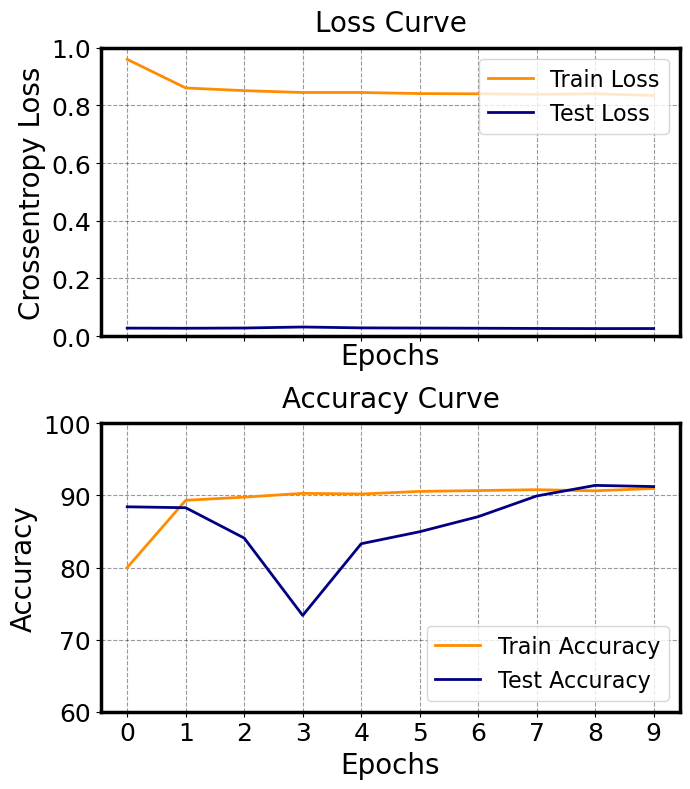

In [38]:
loss_acc_plot(train_losses, valid_losses, train_accuracy, valid_accuracy, 9, "Initial Training",
              interval=1, yloss_limit1=0, yloss_limit2=1.0, yacc_limit1=60, yacc_limit2=100)

save_fig ("loss_accuracy_curve_multimodal")

In [39]:
get_accuracy(model, val_dataloader, device, mode = 'multi_model')

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
test_accuracy_mean, test_accuracy_std, auc_mean, auc_std = model_evaluation(model, val_dataloader, classes, device, classifier_name = "Hybrid-CNN",
                                                                            signal_type = "raw", seed=0, mode = 'multi_model')

save_fig ("ROC_curve (multimodal_fusion-based)")

In [23]:
yt, yp = class_report(model, val_dataloader, device, classes, mode="multi_model")

               precision    recall  f1-score   support

       Cracks     0.0000    0.0000    0.0000       150
  Defect-free     0.9090    0.9310    0.9199      1073
Keyhole pores     0.7489    0.9263    0.8282       570
    Laser-off     1.0000    0.9914    0.9957      1273

     accuracy                         0.9097      3066
    macro avg     0.6645    0.7122    0.6859      3066
 weighted avg     0.8726    0.9097    0.8893      3066



/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

[[   0   56   94    0]
 [   0  999   74    0]
 [   0   42  528    0]
 [   0    2    9 1262]]
Saving figure confusion_matrix(audio_visual)


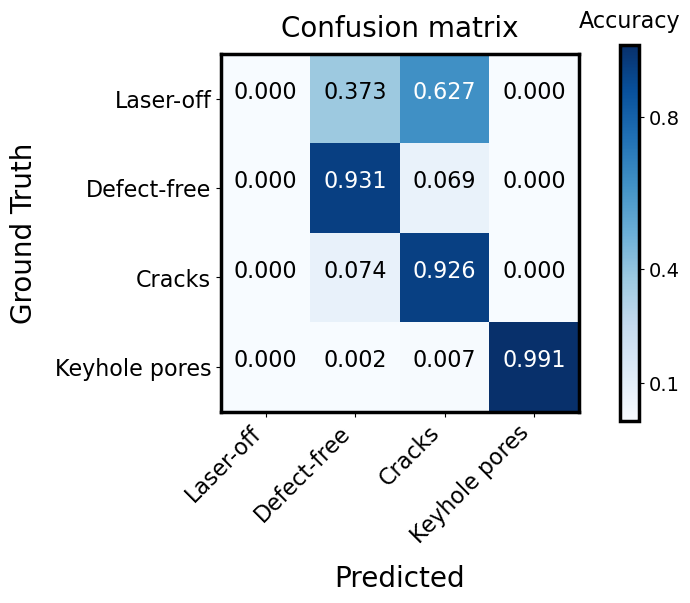

In [24]:
conf_matrix(yt, yp, classes)
save_fig("confusion_matrix(audio_visual)")

In [32]:
model = AudioVisualFusionCNN()
image = torch.randn(1, 1, 32, 32)
audio = torch.randn(1, 1, 32, 7)
predictions = model(image, audio)
# make_dot(predictions.mean(), params=dict(model.named_parameters()))
# make_dot(predictions)
# save_fig("multimodal_structure")
# make_dot(predictions.mean(), params=dict(model.named_parameters()),show_attrs=True, show_saved=True)

In [33]:
input_names = ['Sentence']
output_names = ['yhat']
torch.onnx.export(model, batch.text, 'rnn.onnx', input_names=input_names, output_names=output_names)

NameError: name 'batch' is not defined